# Setup

In [29]:
!pwd

/home/jupyter/work/resources/protein_bert


In [30]:
# The examples in this notebook use a set of nine benchmarks described in our publication.
# These benchmarks can be downloaded from: https://github.com/nadavbra/proteinbert_data_files/tree/master/protein_benchmarks
# Download the benchmarks into a directory on your machine and set the following variable to the path of that directory.
BENCHMARKS_DIR = '/home/jupyter/work/resources'

In [5]:
import pandas as pd 
import numpy as np 

import requests
import zipfile
from io import BytesIO


with open('g4_rna_data.csv') as file:
    df = pd.read_csv(file).drop(columns=['Unnamed: 0'])


In [6]:
df.columns = ['entry', 'seq', 'label']
df

,entry,seq,label
0,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,0
1,A0A0C5B5G6,MRWQEMGYIFYPRKLR,0
2,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,0
3,A0A0U1RRE5,MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...,0
4,A0A1B0GTW7,MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...,0
...,...,...,...
14139,P63104,MDKNELVQKAKLAEQAERYDDMAACMKSVTEQGAELSNEERNLLSV...,1
14140,Q5T200,MSKIRRKVTVENTKTISDSTSRRPSVFERLGPSTGSTAETQCRNWL...,1
14141,Q6PJT7,MEIGTEISRKIRSAIKGKLQELGAYVDEELPDYIMVMVANKKSQDQ...,1
14142,Q8NAF0,MDPQPPPPAQGSPPHRGRGRGRGRGRGRGRGRGRGGAGAPRAPLPC...,1


In [9]:
df = df.groupby('label').apply(lambda x: x.sample(n=1100)).reset_index(drop = True)
df

,entry,seq,label
0,Q96G23,MLQTLYDYFWWERLWLPVNLTWADLEDRDGRVYAKASDLYITLPLA...,0
1,Q76EJ3,MTAGGQAEAEGAGGEPGAARLPSRVARLLSALFYGTCSFLIVLVNK...,0
2,Q92796,MHKHQHCCKCPECYEVTRLAALRRLEPPGYGDWQVPDPYGPGGGNG...,0
3,O60667,MDFWLWPLYFLPVSGALRILPEVKVEGELGGSVTIKCPLPEMHVRI...,0
4,O14495,MQNYKYDKAIVPESKNGGSPALNNNPRRSGSKRVLLICLDLFCLFM...,0
...,...,...,...
2195,Q8WX92,MFAGLQDLGVANGEDLKETLTNCTEPLKAIEQFQTENGVLLPSLQS...,1
2196,P35221,MTAVHAGNINFKWDPKSLEIRTLAVERLLEPLVTQVTTLVNTNSKG...,1
2197,Q96MH2,MMATPNQTACNAESPVALEEAKTSGAPGSPQTPPERHDSGGSLPLT...,1
2198,P62805,MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKR...,1


In [16]:
train_set, valid_set, test_set = np.split(
    df.dropna().sample(frac=1, random_state=42),
    [int(.8*len(df)), int(.9*len(df))]
)

In [17]:
train_set

,entry,seq,label
1451,Q16718,MAGVLKKTTGLVGLAVCNTPHERLRILYTKILDVLEEIPKNAAYRK...,1
1334,P11142,MSKGPAVGIDLGTTYSCVGVFQHGKVEIIANDQGNRTTPSYVAFTD...,1
1761,Q9P015,MAGPLQGGGARALDLLRGLPRVSLANLKPNPGSKKPERRPRGRRRG...,1
1735,Q9UPN3,MSSSDEETLSERSCRSERSCRSERSYRSERSGSLSPCPPGDTLPWN...,1
1576,P62314,MKLVRFLMKLSHETVTIELKNGTQVHGTITGVDVSMNTHLKAVKMT...,1
...,...,...,...
119,Q9UI43,MAGYLKLVCVSFQRQGFHTVGSRCKNRTGAEHLWLTRHLRDPFVKA...,0
656,Q02577,MMLSPDQAADSDHPSSAHSDPESLGGTDTKVLGSVSDLEPVEEAEG...,0
1960,Q96N67,MAERRAFAQKISRTVAAEVRKQISGQYSGSPQLLKNLNIVGNISHH...,1
1904,Q9BXT6,MLSLAAKLVAFFWRTADTPREEAGQLEPELAEGDTKLKTVRGVVTR...,1


In [18]:
# Get train and validation data
train_set=train_set.drop_duplicates().reset_index(drop=True)
valid_set=valid_set.drop_duplicates().reset_index(drop=True)
test_set=test_set.drop_duplicates().reset_index(drop=True)

# Drop unneeded columns
train_set=train_set[["seq","label"]]
valid_set=valid_set[["seq","label"]]
test_set=test_set[["seq","label"]]

<Axes: >

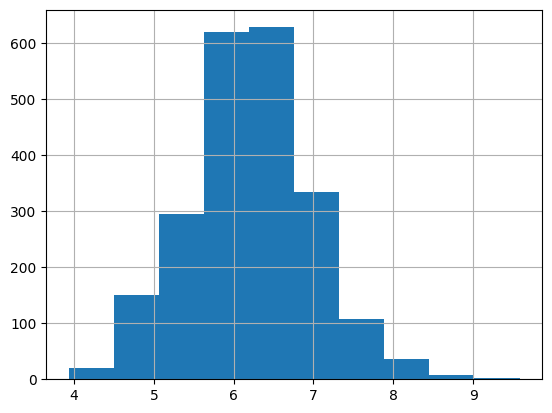

In [19]:
df['seq'].apply(lambda x: np.log(len(x))).hist()

# Fine-tune the model for the signal peptide benchmark

In [20]:
#pragma async
import os

import pandas as pd
from IPython.display import display

from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARK_NAME = 'g4_rna_data.csv'

# A local (non-global) binary output
OUTPUT_TYPE = OutputType(False, 'binary')
UNIQUE_LABELS = [0, 1]
OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)


# Loading the dataset

# train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % BENCHMARK_NAME)
# train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
# train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)

# test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % BENCHMARK_NAME)
# test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

print(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')


# Loading the pre-trained model and fine-tuning it on the loaded dataset

pretrained_model_generator, input_encoder = load_pretrained_model()

# get_model_with_hidden_layers_as_outputs gives the model output access to the hidden layers (on top of the output)
model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
        get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)

training_callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
    keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

finetune(model_generator, input_encoder, OUTPUT_SPEC, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
        seq_len = 3000, batch_size = 16, max_epochs_per_stage = 50, lr = 1e-04, begin_with_frozen_pretrained_layers = True, \
        lr_with_frozen_pretrained_layers = 1e-03, n_final_epochs = 10, final_seq_len = 1024, final_lr = 1e-06, callbacks = training_callbacks)


# Evaluating the performance on the test-set

results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_set['seq'], test_set['label'], \
        start_seq_len = 512, start_batch_size = 128)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)

2024-06-23 09:44:23.815689: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 09:44:26.188420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 09:44:35.374410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1748 training set records, 219 validation set records, 220 test set records.
[2024_06_23-09:45:06] Training set: Filtered out 32 of 1748 (1.8%) records of lengths exceeding 2998.
[2024_06_23-09:45:06] Validation set: Filtered out 3 of 219 (1.4%) records of lengths exceeding 2998.
[2024_06_23-09:45:06] Training with frozen pretrained layers...


2024-06-23 09:45:08.511698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


Epoch 1/50


2024-06-23 09:45:19.655041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2024-06-23 09:45:22.654809: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2c38023f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-23 09:45:22.654857: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-06-23 09:45:22.943192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-23 09:45:24.653823: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 [==============================] - 34s 196ms/step - loss: 0.6036 - val_loss: 0.5429 - lr: 0.0010
Epoch 2/50
108/108 [==============================] - 19s 173ms/step - loss: 0.5248 - val_loss: 0.5136 - lr: 0.0010
Epoch 3/50
108/108 [==============================] - 19s 174ms/step - loss: 0.5017 - val_loss: 0.5010 - lr: 0.0010
Epoch 4/50
108/108 [==============================] - 19s 175ms/step - loss: 0.4889 - val_loss: 0.4976 - lr: 0.0010
Epoch 5/50
108/108 [==============================] - 19s 176ms/step - loss: 0.4738 - val_loss: 0.4938 - lr: 0.0010
Epoch 6/50
107/108 [============================>.] - ETA: 0s - loss: 0.4665WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00025000001

,# records,AUC
Model seq len,,
512,117,0.846154
1024,65,0.755747
2048,33,0.762963
4096,3,1.000000
8192,1,NaN
16384,1,NaN
All,220,0.808130


Confusion matrix:


,0,1
0,68,30
1,27,95


In [25]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)
train

,entry,seq,label
1905,Q9NXF1,MTKKRKRQHDFQKVKLKVGKKKPKLQNATPTNFKTKTIHLPEQLKE...,1
1869,P08670,MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,1
1011,Q9BUH8,MEKLSALQEQKGELRKRLSYTTHKLEKLETEFDSTRHYLEIELRRA...,0
420,Q14330,MITLNNQDQPVPFNSSHPDEYKIAALVFYSCIFIIGLFVNITALWV...,0
472,Q9H1U9,MMDSEAHEKRPPILTSSKQDISPHITNVGEMKHYLCGCCAAFNNVA...,0
...,...,...,...
1530,P11362,MWSWKCLLFWAVLVTATLCTARPSPTLPEQAQPWGAPVEVESFLVH...,1
1311,Q7LGC8,MEKGLTLPQDCRDFVHSLKMRSKYALFLVFVVIVFVFIEKENKIIS...,1
720,O60307,MDESSLLRRRGLQKELSLPRRGRGCRSGNRKSLVVGTPSPTLSRPL...,0
946,Q9H8W4,MVDRLANSEANTRRISIVENCFGAAGQPLTIPGRVLIGEGVLTKLC...,0


In [27]:
model = model_generator.create_model(0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model(test_set['seq'])
cm = confusion_matrix(test_set['label'], y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()


ValueError: Exception encountered when calling layer "wide-conv-block1" (type Conv1D).

Negative dimension size caused by subtracting 9 from 8 for '{{node wide-conv-block1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](wide-conv-block1/Conv1D/ExpandDims, wide-conv-block1/Conv1D/ExpandDims_1)' with input shapes: [?,1,8,128], [1,9,128,128].

Call arguments received by layer "wide-conv-block1" (type Conv1D):
  • inputs=tf.Tensor(shape=(None, 0, 128), dtype=float32)

# Run all benchmarks

In [57]:
import os

import pandas as pd
from IPython.display import display

from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len, log
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARKS = [
    # name, output_type
    ('signalP_binary', OutputType(False, 'binary')),
    ('fluorescence', OutputType(False, 'numeric')),
    ('remote_homology', OutputType(False, 'categorical')),
    ('stability', OutputType(False, 'numeric')),
    ('scop', OutputType(False, 'categorical')),
    ('secondary_structure', OutputType(True, 'categorical')),
    ('disorder_secondary_structure', OutputType(True, 'binary')),
    ('ProFET_NP_SP_Cleaved', OutputType(False, 'binary')),
    ('PhosphositePTM', OutputType(True, 'binary')),
]

settings = {
    'max_dataset_size': None,
    'max_epochs_per_stage': 40,
    'seq_len': 512,
    'batch_size': 32,
    'final_epoch_seq_len': 1024,
    'initial_lr_with_frozen_pretrained_layers': 1e-02,
    'initial_lr_with_all_layers': 1e-04,
    'final_epoch_lr': 1e-05,
    'dropout_rate': 0.5,
    'training_callbacks': [
        keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
        keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
    ],
}

####### Uncomment for debug mode
# settings['max_dataset_size'] = 500
# settings['max_epochs_per_stage'] = 1

def run_benchmark(benchmark_name, pretraining_model_generator, input_encoder, pretraining_model_manipulation_function = None):
    
    log('========== %s ==========' % benchmark_name)  
    
    output_type = get_benchmark_output_type(benchmark_name)
    log('Output type: %s' % output_type)
    
    train_set, valid_set, test_set = load_benchmark_dataset(benchmark_name)        
    log(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')
    
    if settings['max_dataset_size'] is not None:
        log('Limiting the training, validation and test sets to %d records each.' % settings['max_dataset_size'])
        train_set = train_set.sample(min(settings['max_dataset_size'], len(train_set)), random_state = 0)
        valid_set = valid_set.sample(min(settings['max_dataset_size'], len(valid_set)), random_state = 0)
        test_set = test_set.sample(min(settings['max_dataset_size'], len(test_set)), random_state = 0)
    
    if output_type.is_seq or output_type.is_categorical:
        train_set['label'] = train_set['label'].astype(str)
        valid_set['label'] = valid_set['label'].astype(str)
        test_set['label'] = test_set['label'].astype(str)
    else:
        train_set['label'] = train_set['label'].astype(float)
        valid_set['label'] = valid_set['label'].astype(float)
        test_set['label'] = test_set['label'].astype(float)
        
    if output_type.is_categorical:
        
        if output_type.is_seq:
            unique_labels = sorted(set.union(*train_set['label'].apply(set)) | set.union(*valid_set['label'].apply(set)) | \
                    set.union(*test_set['label'].apply(set)))
        else:
            unique_labels = sorted(set(train_set['label'].unique()) | set(valid_set['label'].unique()) | set(test_set['label'].unique()))
            
        log('%d unique lebels.' % len(unique_labels))
    elif output_type.is_binary:
        unique_labels = [0, 1]
    else:
        unique_labels = None
        
    output_spec = OutputSpec(output_type, unique_labels)
    model_generator = FinetuningModelGenerator(pretraining_model_generator, output_spec, pretraining_model_manipulation_function = \
            pretraining_model_manipulation_function, dropout_rate = settings['dropout_rate'])
    finetune(model_generator, input_encoder, output_spec, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
            seq_len = settings['seq_len'], batch_size = settings['batch_size'], max_epochs_per_stage = settings['max_epochs_per_stage'], \
            lr = settings['initial_lr_with_all_layers'], begin_with_frozen_pretrained_layers = True, lr_with_frozen_pretrained_layers = \
            settings['initial_lr_with_frozen_pretrained_layers'], n_final_epochs = 1, final_seq_len = settings['final_epoch_seq_len'], \
            final_lr = settings['final_epoch_lr'], callbacks = settings['training_callbacks'])
    
    for dataset_name, dataset in [('Training-set', train_set), ('Validation-set', valid_set), ('Test-set', test_set)]:
        
        log('*** %s performance: ***' % dataset_name)
        results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, output_spec, dataset['seq'], dataset['label'], \
                start_seq_len = settings['seq_len'], start_batch_size = settings['batch_size'])
    
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(results)
        
        if confusion_matrix is not None:
            with pd.option_context('display.max_rows', 16, 'display.max_columns', 10):
                log('Confusion matrix:')
                display(confusion_matrix)
                
    return model_generator

def load_benchmark_dataset(benchmark_name):
    
    train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % benchmark_name)
    valid_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.valid.csv' % benchmark_name)
    test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % benchmark_name)
    
    train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
    test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()
          
    if os.path.exists(valid_set_file_path):
        valid_set = pd.read_csv(valid_set_file_path).dropna().drop_duplicates()
    else:
        log(f'Validation set {valid_set_file_path} missing. Splitting training set instead.')
        train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)
    
    return train_set, valid_set, test_set

def get_benchmark_output_type(benchmark_name):
    for name, output_type in BENCHMARKS:
        if name == benchmark_name:
            return output_type
        
pretrained_model_generator, input_encoder = load_pretrained_model()

for benchmark_name, _ in BENCHMARKS:
    run_benchmark(benchmark_name, pretrained_model_generator, input_encoder, pretraining_model_manipulation_function = \
            get_model_with_hidden_layers_as_outputs)
        
log('Done.')

[2024_05_24-00:01:33] ========== signalP_binary ==========
[2024_05_24-00:01:33] Output type: global binary


FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/work/resources/signalP_binary.train.csv'

# Visualizing the attention layers

You can run this only after you have fine-tuned the model on a benchmark (e.g. signal peptide) and obtained *model_generator*.

In [28]:
results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_set['seq'], test_set['label'], \
        start_seq_len = 128, start_batch_size = 16)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)

1/1 [==============================] - 2s 2s/step
Test-set performance:


,# records,AUC
Model seq len,,
128,7,0.900000
256,34,0.920139
512,76,0.813025
1024,65,0.755747
2048,33,0.762963
4096,3,1.000000
8192,1,NaN
16384,1,NaN
All,220,0.805453


Confusion matrix:


,0,1
0,66,32
1,26,96


MEPFTNDRLQLPRNMIENSMFEEEPDVVDLAKEPCLHPLEPDEVEYEPRGSRLLVRGLGEHEMEEDEEDYESSAKLLGMSFMNRSSGLRNSATGYRQSPDGACSVPSARTMVVCAFVIVVAVSVIMVIYLLPRCTFTKEGCHKKNQSIGLIQPFATNGKLFPWAQIRLPTAVVPLRYELSLHPNLTSMTFRGSVTISVQALQVTWNIILHSTGHNISRVTFMSAVSSQEKQAEILEYAYHGQIAIVAPEALLAGHNYTLKIEYSANISSSYYGFYGFSYTDESNEKKYFAATQFEPLAARSAFPCFDEPAFKATFIIKIIRDEQYTALSNMPKKSSVVLDDGLVQDEFSESVKMSTYLVAFIVGEMKNLSQDVNGTLVSIYAVPEKIGQVHYALETTVKLLEFFQNYFEIQYPLKKLDLVAIPDFEAGAMENWGLLTFREETLLYDSNTSSMADRKLVTKIIAHELAHQWFGNLVTMKWWNDLWLNEGFATFMEYFSLEKIFKELSSYEDFLDARFKTMKKDSLNSSHPISSSVQSSEQIEEMFDSLSYFKGSSLLLMLKTYLSEDVFQHAVVLYLHNHSYASIQSDDLWDSFNEVTNQTLDVKRMMKTWTLQKGFPLVTVQKKGKELFIQQERFFLNMKPEIQPSDTSYLWHIPLSYVTEGRNYSKYQSVSLLDKKSGVINLTEEVLWVKVNINMNGYYIVHYADDDWEALIHQLKINPYVLSDKDRANLINNIFELAGLGKVPLKRAFDLINYLGNENHTAPITEALFQTDLIYNLLEKLGYMDLASRLVTRVFKLLQNQIQQQTWTDEGTPSMRELRSALLEFACTHNLGNCSTTAMKLFDDWMASNGTQSLPTDVMTTVFKVGAKTDKGWSFLLGKYISIGSEAEKNKILEALASSEDVRKLYWLMKSSLNGDNFRTQKLSFIIRTVGRHFPGHLLAWDFVKENWNKLVQKFPLGSYTIQNIVAGSTYLFSTKTHLSEVQAFFENQSEATFRLRCV

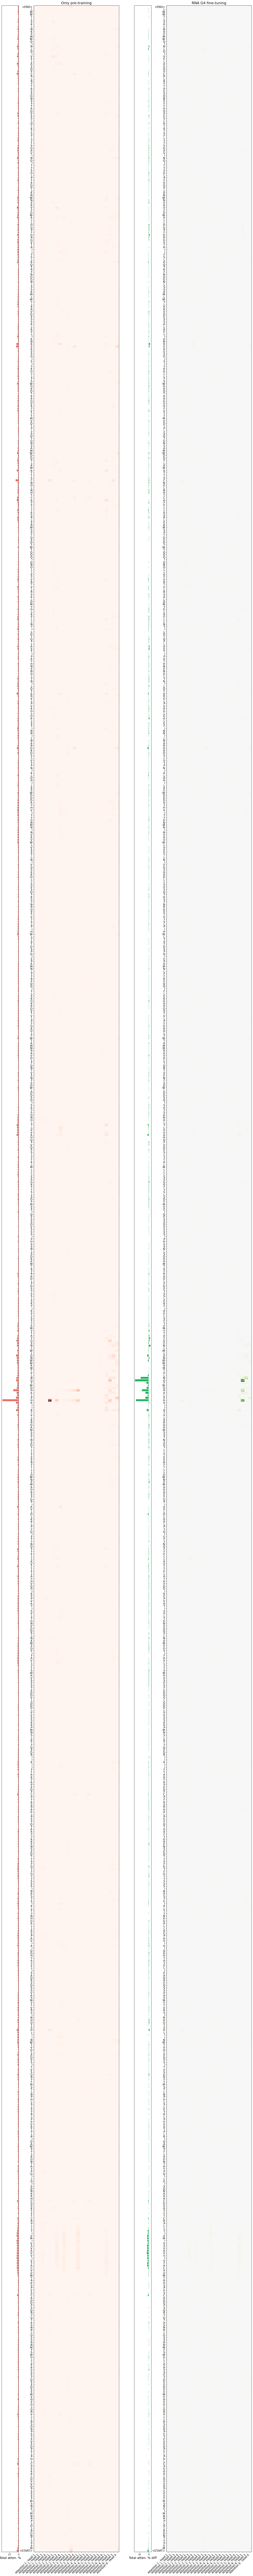

In [17]:
import numpy as np
import matplotlib.pyplot as plt

BENCHMARK_DISPLAY_NAME = 'RNA G4'

# TEST_SET_FILE_PATH = '/cs/phd/nadavb/my_public_ftp_site/protein_bert/protein_benchmarks/signalP_binary.train.csv'
IDEAL_LEN = 1024

def calculate_attentions(model, input_encoder, seq, seq_len = None):
    
    from tensorflow.keras import backend as K
    from proteinbert.tokenization import index_to_token
    
    if seq_len is None:
        seq_len = len(seq) + 2
    
    X = input_encoder.encode_X([seq], seq_len)
    (X_seq,), _ = X
    seq_tokens = list(map(index_to_token.get, X_seq))

    model_inputs = [layer.input for layer in model.layers if 'InputLayer' in str(type(layer))][::-1]
    model_attentions = [layer.calculate_attention(layer.input) for layer in model.layers if 'GlobalAttention' in str(type(layer))]
    invoke_model_attentions = K.function(model_inputs, model_attentions)
    attention_values = invoke_model_attentions(X)
    
    attention_labels = []
    merged_attention_values = []

    for attention_layer_index, attention_layer_values in enumerate(attention_values):
        for head_index, head_values in enumerate(attention_layer_values):
            attention_labels.append('Attention %d - head %d' % (attention_layer_index + 1, head_index + 1))
            merged_attention_values.append(head_values)

    attention_values = np.array(merged_attention_values)
    
    return attention_values, seq_tokens, attention_labels

def plot_attention(attention_values, seq_tokens, attention_labels, ax, cmap = 'Reds', vmin = 0, vmax = None, text_value_threshold = 0.1):

    heatmap = ax.pcolor(attention_values.transpose(), cmap = cmap, vmin = vmin, vmax = vmax)

    ax.set_xticks(np.arange(len(attention_labels)) + 0.5)
    ax.set_xticklabels(attention_labels, rotation = 45, ha = 'right', fontsize = 12)
    ax.set_yticks(np.arange(len(seq_tokens)) + 0.5)
    ax.set_yticklabels(seq_tokens, fontsize = 12)

    for i, row in enumerate(attention_values):
        for j, value in enumerate(row):
            if abs(value) >= text_value_threshold:
                add_plus_sign = attention_values.min() < 0 and value > 0
                plus_sign = '+' if add_plus_sign else ''
                ax.text(i + 0.5, j + 0.5, plus_sign + '%d%%' % (100 * value), color = 'white', ha = 'center', va = 'center', \
                        fontsize = 9, fontweight = 'bold', fontstretch = 'condensed')
                
# test_set = pd.read_csv(TEST_SET_FILE_PATH)
chosen_index = ((test_set['seq'].str.len() - IDEAL_LEN).abs()).sort_values().index[0]
seq = test_set.loc[chosen_index, 'seq']
label = test_set.loc[chosen_index, 'label']
                
seq_len = len(seq) + 2

pretrained_model_generator, input_encoder = load_pretrained_model()
model = pretrained_model_generator.create_model(seq_len)
pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)

model = model_generator.create_model(seq_len)
finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)
assert finetuned_seq_tokens == pretrained_seq_tokens
assert finetuned_attention_labels == pretrained_attention_labels[:len(finetuned_attention_labels)]

fig, axes = plt.subplots(ncols = 4, figsize = (20, 0.2 * seq_len), gridspec_kw = dict(width_ratios = [1, 5, 1, 5]))
fig.subplots_adjust(wspace = 0.3)

axes[0].barh(np.arange(seq_len), 100 * pretrained_attention_values.sum(axis = 0), color = '#EC7063')
axes[0].set_ylim((-0.5, seq_len - 0.5))
axes[0].set_yticks([])
axes[0].invert_xaxis()
axes[0].set_xlabel('Total atten. %', fontsize = 14)

vmax = pretrained_attention_values.max()
plot_attention(pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels, axes[1], cmap = 'Reds', vmax = vmax, \
        text_value_threshold = 0.05)
axes[1].set_title('Only pre-training', fontsize = 16)

axes[2].barh(np.arange(seq_len), 100 * (finetuned_attention_values - pretrained_attention_values).sum(axis = 0), color = '#28B463')
axes[2].set_ylim((-0.5, seq_len - 0.5))
axes[2].set_yticks([])
axes[2].invert_xaxis()
axes[2].set_xlabel('Total atten. % diff', fontsize = 14)

attention_diff = finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]
vmax = np.abs(attention_diff).max()
plot_attention(attention_diff, finetuned_seq_tokens, finetuned_attention_labels, axes[3], cmap = 'PiYG', vmin = -vmax, vmax = vmax, \
        text_value_threshold = 0.03)
axes[3].set_title('%s fine-tuning' % BENCHMARK_DISPLAY_NAME, fontsize = 16)

print(seq, label)
plt.savefig("attention_map.png")

In [ ]:
plt.savefig